In [1]:
import numpy as np
import gym
import keras
from keras.initializers import VarianceScaling
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt
from collections import deque
import itertools
from sklearn.preprocessing import StandardScaler
% matplotlib inline

Using TensorFlow backend.


In [2]:
def build_model(n_inputs, n_outputs, n_hidden=48, lr=0.001):
    model = Sequential([
        Dense(256, input_shape=(n_inputs,), activation="relu", kernel_initializer='he_uniform'),
        Dense(256, activation="relu", kernel_initializer='he_uniform'),
        Dense(n_outputs, activation="linear")
    ])
    
    model.compile(optimizer=RMSprop(lr=lr, clipvalue=1.0),
                  loss="mse")
    return model

In [3]:
def transfer_weights(model, learner, smooth=False):
    if smooth:
        tau = 0.125
        weights = model.get_weights()
        learner_weights = learner.get_weights()
        for i in range(len(weights)):
            weights[i] = learner_weights[i] * tau + weights[i] * (1 - tau)
    else:
        weights = learner.get_weights()
    model.set_weights(weights)
    return model

In [4]:
def report_results(results, episode, episodes, solved, epsilon, rolling, prev_max, step_count):
    best = np.max(results) if results else -1
    rolling = rolling if rolling else [-1]
    roll, variance = np.mean(rolling), np.var(rolling)
    prev_max, best, roll, epsilon = [round(x, 3) for x in (prev_max, best, roll, epsilon)]
    print("episodes: {}/{} - prev steps: {} - prev max: {} - global max: {} - rolling average: {} - epsilon: {}".format(
        episode, episodes, step_count, prev_max, best, roll, epsilon))

In [5]:
def fit_learner(model, replay_buffer, gamma=0.95):
    batchsize = 16
    if len(replay_buffer) < batchsize:
        return model
    memory = np.array(replay_buffer)[np.random.choice(len(replay_buffer), batchsize, replace=False), :]
    priority = memory[memory[:, 4] == True]
    if len(priority) >= 2:
        priority_sample = priority[np.random.choice(len(priority), 2, replace=False), :]
        memory = np.concatenate([memory, priority])
    X, y = np.zeros((len(memory), 6)), np.zeros((len(memory), 3))
    for i, m in enumerate(memory):
        state, action, reward, done, next_state = m[:6], int(m[6]), m[7], m[8], m[9:]
        target = model.predict(state.reshape(-1, 6)).reshape(3)

        if done:
            total_reward = reward
        else:
            total_reward = reward + gamma * np.amax(model.predict(next_state.reshape(-1, 6)))
        target[action] = total_reward
        
        X[i] = state.reshape(-1, 6)
        y[i] = target.reshape(-1, 3)
    
    model.fit(X, y, epochs=1, verbose=0)
    
    return model

In [85]:
def play(model, learner, episodes=500, steps=500, epsilon=1.0, gamma=0.99, render=False):
    env = gym.make("Acrobot-v1")
    replay_buffer = deque(maxlen=100000)
    results = []
    conseq = 0
    for episode in range(episodes):
        state = env.reset()
        episode_memory = np.zeros((steps, 15))

        for step in range(steps):
            env.render() if render else None
            if np.random.random() < epsilon or step < 0:
                action = np.random.randint(3)
            else:
                action = np.argmax(model.predict(state.reshape(-1, 6)).flatten())
            next_state, reward, done, _ = env.step(action)
            v0 = state[1]

            episode_memory[step, :6] = state
            episode_memory[step, 6] = action
            episode_memory[step, 7] = reward
            episode_memory[step, 8] = done
            episode_memory[step, 9:] = next_state

            replay_buffer.append(episode_memory[step])
            state = next_state
            
            learner = fit_learner(learner, replay_buffer, gamma)
            
            if done:
                results.append(step)
                if episode % 4 == 0:
                    print(episode, np.mean(results[-5:]), epsilon)
                if step < 499:
                    conseq += 1
                    if conseq >= 10:
                        print("done.")
                        return model, learner, results
                else:
                    conseq = 0
                break
        
        model = transfer_weights(model, learner)
        epsilon = np.max([epsilon - 0.005, 0.1])

    return model, learner, results

In [86]:
#model = build_model(6, 3)
#learner = build_model(6, 3)
#all_results = []
model, learner, results = play(model, learner, episodes=25, epsilon=0.19, render=False)

0 499.0 0.19
4 289.2 0.17
8 257.2 0.15
12 409.2 0.13
16 389.8 0.11
20 376.4 0.1
24 272.2 0.1


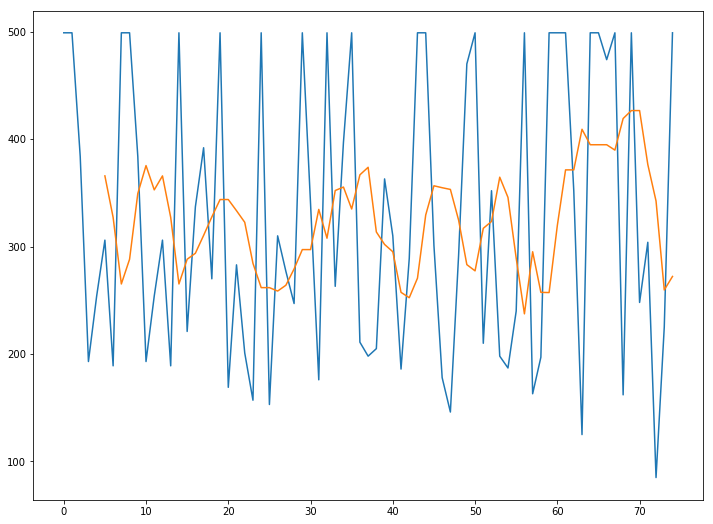

In [87]:
all_results.extend(results)
avs = [np.mean(all_results[i:i + 5]) for i in range(len(all_results) - 5)]
plt.plot(range(len(all_results)), all_results)
plt.plot([x + 5 for x in range(len(avs))], avs)
plt.show()

In [ ]:
env = gym.make("Acrobot-v1")
s = env.reset()
d = False
for e in range(10):
    for i in range(500):
        a = np.argmax(model.predict(s.reshape(-1, 6)))
        s, r, d, _ = env.step(a)
        #env.render()
        if d:
            if i < 499:
                print("done in {} steps".format(i))
            else:
                print("done")
            s = env.reset()
            break   

done in 171 steps
done in 324 steps
done in 259 steps
done in 188 steps
done
done in 202 steps
